# 캡챠 이미지 전처리하기

## 레이블 만들기

In [2]:
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
# 이미지가 저장된 디렉토리 경로 설정
image_dir = 'Datasets_Captcha'
csv_path = 'Datasets_Captcha/Captcha_labels.csv'

# 레이블 데이터를 저장할 데이터 구조 초기화
labels = []

# 디렉토리 내의 모든 파일을 순회
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):  # JPEG 이미지만 처리
        # 파일 이름을 '_' 기준으로 분할
        parts = filename.split('_')
        if len(parts) > 1:
            # 레이블 번호와 캡챠 문자 부분 추출
            label_number = parts[0]
            captcha_text = parts[1].split('.')[0]  # 파일 확장자 제거
            # 이미지 경로와 추출된 레이블을 저장
            labels.append((int(label_number), captcha_text))

# 레이블 번호 기준으로 데이터 정렬
labels.sort(key=lambda x: x[0])

# CSV 파일에 데이터 쓰기
with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # CSV 헤더 작성
    writer.writerow(['CAPTCHA_label'])
    # 데이터 작성
    for _, captcha_text in labels:
        writer.writerow([captcha_text])

# 완료 메시지
print(f'Labels successfully saved to {csv_path}')

Labels successfully saved to Datasets_Captcha/Captcha_labels.csv


In [63]:
labels_df = pd.read_csv(csv_path)
labels_df.head()

,CAPTCHA_label
0,vgxrub
1,ne2bt2
2,tdk6mf
3,hvpvkx
4,6dmens


## 이미지 배열에 넣기

In [64]:
!pip install Pillow

In [3]:
# 라이브러리 불러오기
from PIL import Image

In [4]:
image_path = 'Datasets_Captcha/'
img_list = os.listdir(image_path)
img_list_jpeg = [file for file in img_list if file.endswith(".jpeg")]

# 순번을 기준으로 정렬하기 위해 숫자로 변환된 순번을 포함하는 튜플 리스트 생성
img_list_sorted = sorted(img_list_jpeg, key=lambda x: int(x.split('_')[0]))

In [19]:
import numpy as np

# 이미지를 넘파이 배열로 변환하여 저장
images = []
for img_file in img_list_sorted:
    img_path = os.path.join(image_path, img_file)
    img = Image.open(img_path)
    img_array = np.array(img)
    images.append(img_array)

# 모든 이미지를 포함하는 하나의 넘파이 배열 생성
np_images = np.array(images)

# 결과 확인
print(np_images.shape)

(10001, 50, 250, 3)


In [21]:
# npy 파일로 저장
np.save('Datasets_Captcha/Captcha_images.npy', np_images)

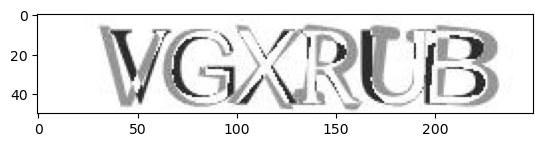

In [22]:
# 첫번째 이미지 출력
plt.imshow(np_images[0])

- (데이터셋의 이미지 수, 높이, 너비, 색상 채널(=rgb))를 의미한다.
    - RGB값이 필요하지 않기 때문에 opencv의 RGB2GRAY를 활용해 흑백변환을 먼저 실시해보자 

In [24]:
# 그레이스케일로 변환
import cv2

greyscaler = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in np_images]

greyscale_captcha = np.array(greyscaler)

In [25]:
# npy 파일로 저장
np.save('Datasets_Captcha/Captcha_greyscaled.npy', greyscale_captcha)

In [26]:
# 그레이스케일된 배열의 크기 확인
print(greyscale_captcha.shape)

(10001, 50, 250)


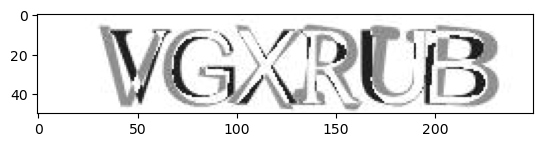

In [29]:
# 첫번째 이미지 출력
plt.imshow(greyscale_captcha[0], cmap='gray')

## PCA를 활용한 차원 축소

In [30]:
# 일단 임의로 100개를 사용한다.
from sklearn.decomposition import PCA
greyscale_captcha = greyscale_captcha.reshape(10001, 50*250)
pca = PCA(n_components=1500)
pca.fit(greyscale_captcha)
captcha_pca = pca.transform(greyscale_captcha)

In [31]:
print(np.sum(pca.explained_variance_ratio_))

0.9101546594468621


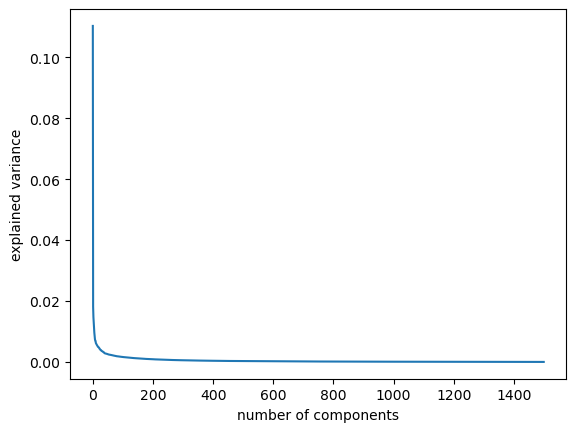

In [32]:
# 설명된 분산 그래프 시각화
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

- 추가적인 전처리가 가능한가는 확인해봐야 할 것 같습니다.

In [33]:
# PCA 역변환
captcha_inverse = pca.inverse_transform(captcha_pca)
print(captcha_inverse.shape)

(10001, 12500)


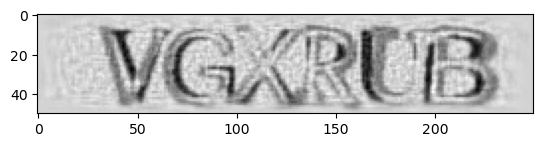

In [34]:
# 역변환된 이미지 시각화
plt.imshow(captcha_inverse[0].reshape(50, 250), cmap='gray')

In [35]:
# pca 변환 npy 파일로 저장
np.save('Datasets_Captcha/Captcha_pca.npy', captcha_pca)

- 역변환된 이미지가 잘 나오는 것을 확인할 수 있습니다.
- 이미지에 대한 전처리는 마쳤습니다